In [1]:
import random

import numpy as np
from sklearn.datasets import load_iris
import sys
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier



In [19]:
class Dense_Layer:
    def __init__(self, input_size, n_neurons):
        epsilon_init = 0.12
        # self.w = np.random.rand(input_size, n_neurons) * 2 * epsilon_init - epsilon_init
        self.input_size = input_size
        self.n_neurons = n_neurons
        self.w = np.random.RandomState(1).normal(loc=0.0, scale=0.1, size=(input_size, n_neurons))
        self.b = np.ones((1, n_neurons))
        # self.w = np.random.rand(input_size, n_neurons) * 0.01


        # Adam parameters
        #
        self.Vdw_prev = 0
        self.Vdb_prev = 0
        self.Sdw_prev = 0
        self.Sdb_prev = 0
        self.t = 1

        # epsilon_init = 0.12
        # self.w = np.random.rand(input_size, n_neurons) * 2 * epsilon_init - epsilon_init


    def forward(self, dense_input):
        self.z = np.dot(dense_input, self.w) + self.b
        return self.z

    def output_layer_forward(self, dense_input):
        self.z = np.dot(dense_input, self.w) + self.b

        
        return self.z

    def dropout(self, activation):
        self.keep_rate = 0.75
        # self.dropout2_mask = np.random.randn(activation.shape[0], activation.shape[1]) < self.keep_rate

        self.dropout_mask = np.ones(shape=(activation.shape[0], activation.shape[1])).reshape((1, -1)) == 1

        # print(self.dropout_mask)
        inactive_neurons = int(self.dropout_mask.shape[1] - (self.dropout_mask.shape[1] * self.keep_rate))
        inactive_neurons_indices = sorted(random.sample(range(0, self.dropout_mask.shape[1]), inactive_neurons))

        self.dropout_mask[0][inactive_neurons_indices] = 0
        self.dropout_mask = self.dropout_mask.reshape(activation.shape[0], activation.shape[1])

        # activation1 = (activation * self.dropout2_mask) / self.keep_rate
        activation *= self.dropout_mask
        return activation


    def adam(self, B1, B2, EPSILON, dw, db, eta):
        Vdw = B1 * self.Vdw_prev + (1 - B1) * dw
        Vdb = B1 * self.Vdb_prev + (1 - B1) * db

        # Vdw = Vdw / (1 - B1 ** self.t)
        # Vdb = Vdb / (1 - B1 ** self.t)

        self.Vdw_prev = Vdw
        self.Vdb_prev = Vdb

        Sdw = B2 * self.Sdw_prev + (1 - B2) * (dw ** 2)
        Sdb = B2 * self.Sdb_prev + (1 - B2) * (db ** 2)

        # Sdw = Sdw / (1 - B2 ** self.t)
        # Sdb = Sdb / (1 - B2 ** self.t)

        self.Sdw_prev = Sdw
        self.Sdb_prev = Sdb


        self.t += 1

        self.w -= eta * (Vdw / (sqrt(Sdw.sum()) + EPSILON))
        self.b -= eta * (Vdb / (sqrt(Sdb.sum()) + EPSILON))

    def adam_output(self, B1, B2, EPSILON, dw, db, eta):
        Vdw = B1 * self.Vdw_prev + (1 - B1) * dw
        Vdb = B1 * self.Vdb_prev + (1 - B1) * db

        # Vdw = Vdw / (1 - B1 ** self.t)
        # Vdb = Vdb / (1 - B1 ** self.t)

        self.Vdw_prev = Vdw
        self.Vdb_prev = Vdb

        Sdw = B2 * self.Sdw_prev + (1 - B2) * (dw ** 2)
        Sdb = B2 * self.Sdb_prev + (1 - B2) * (db ** 2)

        # Sdw = Sdw / (1 - B2 ** self.t)
        # Sdb = Sdb / (1 - B2 ** self.t)

        self.Sdw_prev = Sdw
        self.Sdb_prev = Sdb

        self.t += 1

        self.w -= eta * (Vdw / (sqrt(Sdw.sum()) + EPSILON))
        self.b -= eta * (Vdb / (sqrt(Sdb.sum()) + EPSILON))


class AtlasNN:

    def __init__(self, n_hidden=2, epochs=150, eta=0.005, l2=0.01, batch_size=5, seed=1, adapter_weights=None, adapter_bias=None):
        self.n_hidden = n_hidden
        self.batch_size = batch_size
        self.epochs = epochs
        self.eta = eta
        self.l2 = l2
        self.random = np.random.RandomState(1)
        self.adapter_weights = adapter_weights
        self.adapter_bias = adapter_bias
        if self.adapter_weights != None:
          self.aaa = self.adapter_weights / np.sum(self.adapter_weights, axis=1, keepdims=True)
        self.i = 0

    def one_hot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
          onehot[val, idx] = 1.
        return onehot.T


    def relu(self, z):
        return np.maximum(0, z)
      
    def derivative_relu(self, x):
        return np.array(x > 0,  dtype=np.float32)

    def tanh(self, z):
      return np.tanh(z)

    def derivative_tanh(self, z):
        return (1 - np.power(z, 2))

    def sigmoid(self, z):
        return (1 / (1 + np.exp(-z)))

    def derivative_sigmoid(self, z):
        return z * (1 - z) 
    

    def softmax(self, z, x_data, y_data, num_examples):
        scores = z

        # print('result matrix')
        # print(scores.shape)

        # u, s, vt = np.linalg.svd(scores)

        # print('SVD properties')
        # print(u.shape)
        # print(s.shape)
        # print(vt.shape)
        # scores = z - np.max(z)

        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # dscores = probs
        # print(dscores[range(num_examples), y_data])
        # dscores[range(num_examples), y_data] -= 1
        # dscores /= num_examples

        if self.adapter_weights != None:
          probs = self.linear_adapter(probs, x_data, y_data)

        # print('linear results')
        # print(res)

        return probs
        # return res

    def cross_entropy_derivative(self, nn,y):
        nn = nn.clip(min=1e-8,max=None)
        #print('\n\nCED: ', np.where(y==1,-1/X, 0))
        return np.where(y==1,-1/nn, 0)

    def knn_proba(self, knn, x_data, labels):
        knn.fit(x_data, labels)
        print(knn.kneighbors_graph(x_data).toarray().shape)
        print(knn.get_params())
        print('knn trained!!')

    def linear_adapter(self, softmax_activation, x_data, y_data):

        f_activation = []
        result = []
        
        for sample in x_data:
          array = np.sum(self.adapter_bias + np.dot(sample, self.aaa), axis=0)
          f_activation.append([array[0], array[1], array[2]])
        
        f_function = np.array(f_activation).reshape((3, 3))
        # if self.i == 0:
        #   self.i+=1
          # print(softmax_activation)
          # print(f_function / np.sum(f_function, axis=1, keepdims=True))
          # print(x_data)
          # print(softmax_activation.shape)
          # print((f_function / np.sum(f_function, axis=1, keepdims=True)).shape)
          
        f_function /= np.sum(f_function, axis=1, keepdims=True)

        result = [[0,0,0],
                    [0,0,0],
                    [0,0,0]]
        for i in range(softmax_activation.shape[0]):
           for j in range(softmax_activation.shape[1]):
              result[i][j] = softmax_activation[i][j] * f_activation[i][j]
        result /= np.sum(result, axis=1, keepdims=True)
          # print(result)
        return result
        # return np.argmax(np.sum(bias + np.dot(x[23, [0, 1, 2]].T, melted_weights), axis=0))

    def fit(self, x_data, y_data, x_test_data, y_test_data, input_size):
        self.h1_layer = Dense_Layer(input_size, 100)
        self.h2_layer = Dense_Layer(100, 100)
        self.output_layer = Dense_Layer(100, 3)

        step_size = self.eta
        reg = 0.02

        #Adam params
        B1 = 0.9
        B2 = 0.999
        EPSILON = 1e-10
        batch_size = 3#32

        self.train_scores = []
        self.test_scores = []

        # knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
        i = 0

        y_train_one_hot = self.one_hot(y_data, 3)

        for i in range(self.epochs):

            indices = np.arange(x_data.shape[0])
            np.random.shuffle(indices)

            for idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
              batch_idx = indices[idx:idx + batch_size]

              z1 = self.h1_layer.forward(x_data[batch_idx])
              h1 = self.sigmoid(z1)
              # h1 = self.h1_layer.dropout(h1)

              z2 = self.h2_layer.forward(h1)
              h2 = self.sigmoid(z2)
              h2 = self.h2_layer.dropout(h2)

              z3 = self.output_layer.output_layer_forward(h2)

              # if i == 0:
              #   self.knn_proba(knn, x_data[batch_idx], y_data[batch_idx])
              #   i=i+1

              dscores = self.softmax(z3, x_data[batch_idx], y_data[batch_idx], x_data[batch_idx].shape[0])

              ###
              ##
              #   BACKPROPAGATION
              ##
              ###
              # print('dscores')
              # print(dscores)
              # print('real')
              # print(y_train_one_hot[batch_idx])
              dz_out = dscores - y_train_one_hot[batch_idx]
              dw_out = np.dot(h2.T, dz_out)
              db_out = np.sum(dscores, axis=0, keepdims=True)

              ###### hidden layer error #####
              dz2 = np.dot(dz_out, self.output_layer.w.T) * self.derivative_sigmoid(h2)
              # dh2[h2 <= 0] = 0

              # dh2 = dh2 * self.h2_layer.dropout_mask / self.h2_layer.keep_rate
              # self.h2_layer.dropout(dh2)

              #### !!!! dropout in backpropagation !!!!! ######
              dz2 = dz2 * self.h2_layer.dropout_mask
              dw2 = np.dot(h1.T, dz2)
              db2 = np.sum(dz2, axis=0, keepdims=True)

              ### -----> should be after of before gradient calculation <----- ####
              # dh2 = dh2 * self.h2_layer.dropout_mask

              ###### hidden layer error #####
              dz1 = np.dot(dz2, self.h2_layer.w.T) * self.derivative_sigmoid(h1)
              # dh1[dh1 <= 0] = 0

              # dh1 = dh1 * self.h1_layer.dropout_mask / self.h1_layer.keep_rate
              # dh1 = dh1 * self.h1_layer.dropout_mask
              # self.h1_layer.dropout(dh1)

              dw1 = np.dot(x_data[batch_idx].T, dz1)
              db1 = np.sum(dz1, axis=0, keepdims=True)

              # without - elipse decision boundary, with - straight line
              # dw_out += self.l2 * self.output_layer.w
              # dw2 += self.l2 * self.h2_layer.w

              self.h1_layer.adam_output(B1, B2, EPSILON, dw1, db1, step_size)

              self.h2_layer.adam(B1, B2, EPSILON, dw2, db2, step_size)

              self.output_layer.adam(B1, B2, EPSILON, dw_out, db_out, step_size)

            # train_pred = self.predict(x_data)
            # train_acc = accuracy_score(train_pred, y_train)
            # self.train_scores.append(train_acc)

            # test_pred = self.predict(x_test_data)
            # test_acc = accuracy_score(test_pred, y_test)
            # self.test_scores.append(test_acc)
            # print('accuracy: %.2f' % (np.mean(predicted_class == y_test_data)))

    def predict(self, x):
        z1 = self.h1_layer.forward(x)
        h1 = self.relu(z1)

        z2 = self.h2_layer.forward(h1)
        h2 = self.relu(z2)

        scores = self.output_layer.forward(h2)

        predicted_class = np.argmax(scores, axis=1)
        return predicted_class

    def plot_decision_regions(self, x, y, test_idx=None, resolution=0.02):
        markers = ('s', 'x', 'o', '^', 'v')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        # x = x[:, :2]
        x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))
        z = self.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        z = z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

        a = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1], alpha=0.6, color=cmap(idx), marker=markers[idx], label=a[cl],
                        edgecolors='black')
        plt.legend(loc='upper left')


In [62]:
epoch=800
# atlasNN = AtlasNN(eta=0.25019, epochs=epoch)
atlasNN = AtlasNN(eta=0.001, epochs=epoch)

iris = load_iris()
x = iris.data
y = iris.target

std = StandardScaler()
x = std.fit_transform(x)

##
#3
##
# ----------------------------------- New dataset

# x, y = make_classification(n_samples=10000, n_features=4, n_informative=3, n_redundant=1, n_classes=3, random_state=1)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

pca = PCA(n_components=2)
# x = pca.fit_transform(x)
# x_train = pca.fit_transform(x_train)
# x_test = pca.fit_transform(x_test) * -1


atlasNN.fit(x_train, y_train, x_test, y_test, x_train.shape[1])
atlasNN.plot_decision_regions(x_train, y_train)
plt.show()
# atlasNN.plot_decision_regions(x_test, y_test)
# plt.show()

print('Train: ', np.sum(atlasNN.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
print('Test: ', np.sum(atlasNN.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])

values = [i for i in range(0, epoch)]
plt.plot(values, atlasNN.train_scores, '-o', label='Train')
plt.plot(values, atlasNN.test_scores, '-o', label='Test')
plt.legend()
plt.show()

# arr = np.arange(40)

# print(arr[10: 20].shape)


matrix=np.random.randint(5, size=(90,3))
# matrix=np.array([[1,1,1,0,0],[3,3,3,0,0],[4,4,4,0,0],[5,5,5,0,0],[0,2,0,4,4],[0,0,0,5,5],[0,1,0,2,2]])
# print(matrix)
u, s, vt = np.linalg.svd(matrix)
print(u.shape)
print(s)
print(vt)
# print(np.matrix.round(u,2))
# print(np.matrix.round(s,2))
# print(np.matrix.round(vh,2))


(5, 5)
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
knn trained!!


ValueError: ignored

In [4]:
iris = load_iris()
x = iris.data
y = iris.target

std = StandardScaler()
x = std.fit_transform(x)

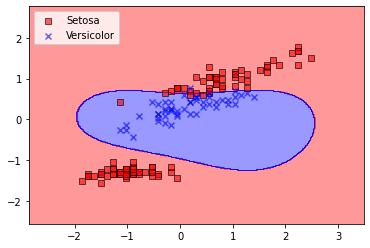

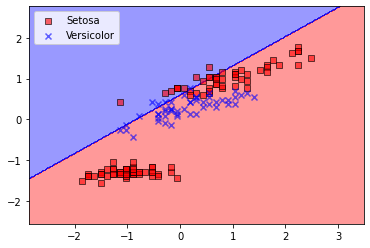

NameError: ignored

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm

# x_train = x[:100, [0, 2]]
# y_train = y[:100]

x_train = x[:150, [0, 2]]
y_train = y[:150]

labels = np.unique(y_train)


# epoch=100
# atlasNN = AtlasNN(eta=0.11, epochs=epoch)

two_class_labels = []
weights_list = []
lr = LogisticRegression(C=1000.0, random_state=1)
# for idx, val in enumerate(labels):
#   two_class_labels = []
for i in range(y.shape[0]):
  if y[i] == 1:
    two_class_labels.append(1)
  else:
    two_class_labels.append(0)
  # atlasNN.fit(x_train, np.array(two_class_labels), [], [], x_train.shape[1])
  # atlasNN.plot_decision_regions(x_train, np.array(two_class_labels)
  # plt.show()

# x_train, x_test, y_train, y_test = train_test_split(x_train, np.array(two_class_labels), test_size=0.3, random_state=1, stratify=y)

clf = svm.SVC()
clf.fit(x_train, two_class_labels)
plot(x_train, two_class_labels, clf)
plt.show()

lr.fit(x_train, two_class_labels)
plot(x_train, two_class_labels, lr)
plt.show()

epoch=200
# atlasNN = AtlasNN(eta=0.25019, epochs=epoch)
atlasNN = AtlasNN(eta=0.03, epochs=epoch)

atlasNN.fit(x_train, np.array(two_class_labels), [], [], x_train.shape[1])
atlasNN.plot_decision_regions(x_train, two_class_labels)
plt.show()

# atlasNN.fit(x_train, y_train, [], [], x_train.shape[1])
# atlasNN.plot_decision_regions(x_train, y_train)
# plt.show()

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm

def plot(x, y, lr, test_idx=None, resolution=0.02):
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # x = x[:, :2]
  x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
  x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
  np.arange(x2_min, x2_max, resolution))
  z = lr.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  z = z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  a = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=x[y == cl, 0], y=x[y == cl, 1], alpha=0.6, color=cmap(idx), marker=markers[idx], label=a[cl],
    edgecolors='black')
    plt.legend(loc='upper left')



# x_train = x[:100, [0, 2]]
# y_train = y[:100]

x_train = x[:150, [0, 2, 3]]
y_train = y[:150]

labels = np.unique(y_train)

# epoch = 100
# atlasNN = AtlasNN(eta=0.11, epochs=epoch)

two_class_labels = []
weights_list = []
lr = LogisticRegression(C=1000.0, random_state=1)
clf = svm.SVC()
melted_weights = []
bias = []

for idx, val in enumerate(labels):
  two_class_labels = []
  for i in range(y.shape[0]):
    if y[i] == val:
      two_class_labels.append(1)
    else:
      two_class_labels.append(0)
  if val == 1:
    clf.fit(x_train, two_class_labels)
    print(np.sum(clf.support_vectors_, axis=0))
    # plot(x_train, two_class_labels, clf)
    # plt.show()
    melted_weights.append(np.sum(clf.support_vectors_, axis=0))
    bias.append(clf.intercept_)
  else:
    lr.fit(x_train, two_class_labels)
    print(lr.coef_.ravel())
    # plot(x_train, two_class_labels, lr)
    # plt.show()
    melted_weights.append(lr.coef_.ravel())
    bias.append(lr.intercept_)


print(np.array(bias).shape)
print(x[149].shape)
print(np.array(melted_weights).shape)
print('Result')
# print((bias + np.dot(x[149, [0, 1, 2]].T, melted_weights)))

# q = np.array([[-16.44300347, -20.3190727,  -22.56697013],
#               [-16.01201568, -19.6517545,  -24.43155689],
#               [-15.78711386, -20.87569303, -24.23575341],
#               [-21.21341109, -15.57864768, -23.97031816],
#               [-20.433138,   -16.82906322, -22.26475414]])
q = np.array([[-16.44300347, -20.3190727,  -22.56697013],
              [-16.01201568, -19.6517545,  -24.43155689]])

for sample in q:
  print(sample)
  print(np.sum(bias + np.dot(x[23, [0, 1, 2]], melted_weights), axis=0))
# print(lr.coef_)
# print(np.sum(clf.support_vectors_, axis=0))
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=1, stratify=y)

# clf.fit(x_train, two_class_labels)
# plot(x_train, two_class_labels, clf)
# plt.show()

# lr.fit(x_train, two_class_labels)
# plot(x_train, two_class_labels, lr)
# plt.show()

epoch=1500
# atlasNN = AtlasNN(eta=0.25019, epochs=epoch)
# atlasNN = AtlasNN(eta=0.003, epochs=epoch)
atlasNN = AtlasNN(eta=0.003, epochs=epoch, adapter_weights=melted_weights, adapter_bias=bias)

# atlasNN.fit(x_train, np.array(two_class_labels), [], [], x_train.shape[1])

# atlasNN.plot_decision_regions(x_train, two_class_labels)
# plt.show()

atlasNN.fit(x_train, y_train, x_test, y_test, x_train.shape[1])


# atlasNN.fit(x, y, [], [], x_train.shape[1])
# atlasNN.plot_decision_regions(x_train, y_train)
# plt.show()

print('Train: ', np.sum(atlasNN.predict(x_train) == y_train).astype(np.float) / x_train.shape[0])
print('Test: ', np.sum(atlasNN.predict(x_test) == y_test).astype(np.float) / x_test.shape[0])

[-0.01827133 -8.54939834 -7.34949946]
[ 9.87922037 17.105792   14.64451928]
[-3.00745256 16.18145695  7.50315504]
(3, 1)
(4,)
(3, 3)
Result
[-16.44300347 -20.3190727  -22.56697013]
[  2.23146722 -29.94315553  -6.85661514]
[-16.01201568 -19.6517545  -24.43155689]
[  2.23146722 -29.94315553  -6.85661514]
Train:  0.8285714285714286
Test:  0.8222222222222222


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# Nowa sekcja

# Nowa sekcja

In [1]:
import numpy as np
a = np.array([[1, 2, 3], [4, 5, 6]])
print(a)

print(np.sum(a, axis = 1, keepdims = True))

[[1 2 3]
 [4 5 6]]
[[ 6]
 [15]]
